!! This is best used with a T4 on colab at the moment. !!
https://colab.research.google.com/drive/1BF_e_MeH1eESmkB0WiQ9G31-18X_eyd4?usp=sharing

## Setup:

In [ ]:
# Only missing dependency on colab
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from google.colab import drive
import random
import pandas as pd
import numpy as np # should be lower than 2 that's why I'm running on colab
import torch
import seaborn as sns
import os
from tqdm import tqdm
from transformers import AutoTokenizer
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
import datasets

In [ ]:
drive.mount('/content/drive') # Do everything on drive not local sessionn

seed = 100

# TODO: Set the following directories up
model = "/content/drive/MyDrive/sensationalism/model" # Pointing towards the model folder containing the weights etc.
data_dir = "/content/drive/MyDrive/sensationalism/failed_sep" # Pointing to the data directory containing all csv files with reddit posts and titles
new_data_dir = "/content/drive/MyDrive/sensationalism/new_data" # Output directory

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def enforce_reproducibility(seed=1000):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For atomic operations there is currently
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    random.seed(seed)
    np.random.seed(seed)

## Testing and WIP

In [ ]:

device = torch.device("cpu")
if torch.cuda.is_available():
    print("Using CUDA")
    device = torch.device("cuda")

seed = 100
enforce_reproducibility(seed)
model = "/content/drive/MyDrive/sensationalism/model"

tk = AutoTokenizer.from_pretrained(model)

pipe = pipeline(
    model=model,
    tokenizer=tk,
    device=device,
    task="text-classification",
    # function_to_apply='none' if args.task == 'sensationalism' else 'softmax', # Regression
    truncation="longest_first",
    max_length=512,
)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/sensationalism/data/science_submissions_2016_01.csv_jargon.csv")
df.head()


,id,author,created_utc,subreddit,score,url,title,domain,ups,downs,link_flair_text,author_flair_text,num_comments,comment_id,comment,comment_url,jargon_proportion
0,3yyyen,CUniversidad,1451608428,science,1,https://www.youtube.com/watch?v=CAqE61zrApA,comunicion,youtube.com,1,0,NaN,NaN,2.0,NaN,NaN,NaN,NaN
1,3yz2zm,rachid-science,1451611151,science,1,https://www.youtube.com/attribution_link?a=W5Y...,chimie expérimentale (La distillation),youtube.com,1,0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2,3yz3yw,margobra8,1451611750,science,7,http://gizmodo.com/japanese-physicists-win-nam...,Japanese Physicists Win Naming Rights for Elem...,gizmodo.com,7,0,Chemistry,NaN,8.0,NaN,NaN,NaN,0.00
3,3yz50u,Computatrum_,1451612385,science,8,http://www.dailymail.co.uk/sciencetech/article...,Researchers captured the first recording of a ...,dailymail.co.uk,8,0,Neuroscience,NaN,3.0,cyhwx5e,I noticed that as well. Tricked me into scroll...,NaN,0.12
4,3yz7qg,mahir369,1451614082,science,1,http://imgur.com/ACHML4D,If Willy Wonka taught Calc 3,imgur.com,1,0,NaN,NaN,1.0,NaN,NaN,NaN,NaN


<Axes: xlabel='score', ylabel='Count'>

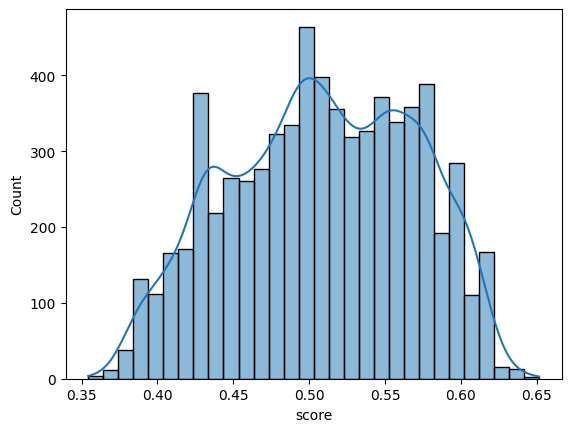

In [ ]:
sns.histplot(df["score"], kde=True)

In [ ]:
df.to_csv("/content/drive/MyDrive/sensationalism/new_data/science_submissions_2016_01.csv_jargon_score.csv")

## Running this on scale:

In [ ]:
if torch.cuda.is_available():
    print("Using CUDA")
    device = torch.device("cuda")
else:
    print("Using CPU")
    raise Warning("Using CPU! This could be way faster on a T4 runtime by google")
    device = torch.device("cpu")

enforce_reproducibility(seed)

tk = AutoTokenizer.from_pretrained(model)

pipe = pipeline(
    model=model,
    tokenizer=tk,
    device=device,
    task="text-classification",
    truncation="longest_first",
    max_length=512,
)

i = 1
for filename in tqdm(os.listdir(data_dir)):

    if filename.endswith(".csv"):
        input_file = os.path.join(data_dir, filename)
        output_file = os.path.join(new_data_dir, filename[:-4] + "_sensationalism_score.csv")

        if not os.path.exists(output_file):
            print(f"Processing {filename} ({i} out of {len(os.listdir(data_dir))})")
            try:
              df = pd.read_csv(input_file)
              if device == torch.device("cuda"):
                dataset = datasets.Dataset.from_pandas(df)
                df["sensationalism_score"] = pipe(dataset["title"], truncation=True)
                df["sensationalism_score"] = df["sensationalism_score"].apply(lambda x: x["score"])
              else:
                df["sensationalism_score"] = 0.0
                for row in tqdm(df.itertuples(), total=df.shape[0]):
                  score = pipe(row.title)[0]["score"]
                  df.loc[row.Index, "sensationalism_score"] = score
              df.to_csv(output_file)
              print(f"\nSaved results to {output_file}")
            except Exception as e:
              print(f"Error processing {filename}: {e}")
        else:
            print(f"Skipping {filename} - already processed.")
    i += 1

Using CUDA


  0%|          | 0/1 [00:00<?, ?it/s]

Processing science_submissions_2017_09.csv_jargon - science_submissions_2017_09.csv_jargon.csv (1 out of 1)


100%|██████████| 1/1 [01:18<00:00, 78.06s/it]


Saved results to /content/drive/MyDrive/sensationalism/new_data/science_submissions_2017_09.csv_jargon - science_submissions_2017_09.csv_jargon_sensationalism_score.csv
